# Homework 7 *\[handout\]*

In [1]:
from dataclasses import dataclass
import enum

import numpy as np
import matplotlib.pyplot as plt

# your additional imports here
from dataclasses import field
from typing import Dict, List

In [2]:
RNG = np.random.default_rng()

# your additional global initialization here

## §1. Implementing generic Markov chain simulations

#### CODE: `Model` interface

In [3]:
class Model:

    def transition_rate(self, state):
        """Total transition rate out of the given state"""
        raise NotImplementedError

    def sample_next(self, state):
        """Generates a random state to come after the given state"""
        raise NotImplementedError

#### CODE: simulating *discrete-time* Markov chains

In [4]:
def run_dtmc(model: Model, state_init, n_steps=256):
    path = [state_init]
    for i in range(n_steps):
        path.append(model.sample_next(path[-1]))
    # Return a list of (time, state) pairs
    # This simulation is discrete-time, so time is an integer
    return list(enumerate(path))

#### CODE: `QueueModel` example

In [5]:
@dataclass
class QueueModel(Model):
    """Model of a queue

    The state is the number of customers currently in the queue.

    Parameters
    ----------
    rate_arrival: float
        Rate at which customers arrive at the queue.

    rate_service: float
        Rate at which customers leave the queue when it is nonempty.
    """

    rate_arrival: float
    rate_service: float

    def transition_rate(self, state: int):
        if state == 0:
            return self.rate_arrival
        else:
            return self.rate_arrival + self.rate_service

    def sample_next(self, state: int):
        if RNG.random() < self.rate_arrival / self.transition_rate(state):
            return state + 1
        else:
            return state - 1

In [6]:
def visualize_queue_path(path):
    plt.plot(*np.asarray(path).T)

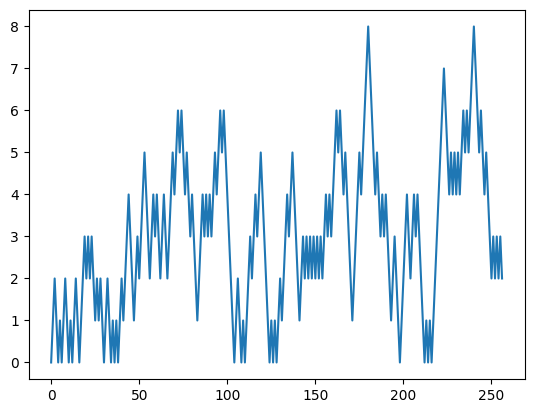

In [7]:
visualize_queue_path(run_dtmc(QueueModel(5, 6), 0))

In [8]:
def run_ctmc(model : Model, state_init, n_steps=256):
    "Continuous-time version of `run_dtmc`"""
    current_time = 0.0
    path = [(current_time, state_init)]
    
    while current_time <= n_steps:
        current_state = path[-1][1]
        rate = model.transition_rate(current_state) 
        current_time += RNG.exponential(1/rate)
        path.append((current_time, model.sample_next(current_state)))
    # Return a list of (time, state) pairs
    return path

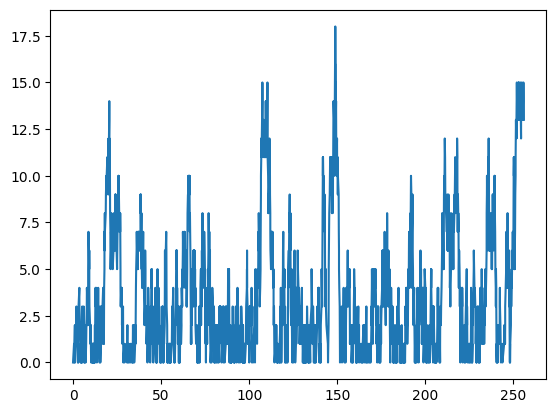

In [9]:
# An initial test
visualize_queue_path(run_ctmc(QueueModel(5, 6), 0))

## §2. Implementing initial model for the project

In [10]:
# You could change these to use tuples instead of
# having separate fields for each level...

@dataclass(frozen=True)
class SimpleWorkplaceState:
    levels: List[str] = field(default_factory=list)
    identities: List[str] = field(default_factory=list)
    state: Dict[str, Dict[str, int]] = field(default_factory=dict)
    
    def __post_init__(self):
        n = len(self.levels)
        m = len(self.identities)
                
        # Validate State
        if len(self.state.keys()) != n:
            raise ValueError(f"State does not match levels: {self.state.keys()} (# levels {n})")
        for level in self.levels:
            if len(self.state[level].keys()) != m:
                raise ValueError(f"State does not match identities: ({self.state[level].keys()} {level}) (# identities {m})")
    

@dataclass(frozen=True)
class SimpleWorkplaceParams:
    levels: List[str] = field(default_factory=list) # Levels must be in order of lowest to highest within the list
    identities: List[str] = field(default_factory=list)
    employee_targets: Dict[str, int] = field(default_factory=dict)
    weights: Dict[str, Dict[str, int]] = field(default_factory=dict)
    lambdas: Dict[str, Dict[str, int]] = field(default_factory=dict)
        
    def __post_init__(self):
        n = len(self.levels)
        m = len(self.identities)
        
        # Validate employee targets
        if len(self.employee_targets.keys()) != n:
            raise ValueError(f"Targets do not match levels: {self.employee_targets.keys()} (# levels {n})")
          
        # Validate weights
        if len(self.weights.keys()) != n:
            raise ValueError(f"Weights do not match levels: {self.weights.keys()} (# levels {n})")
        for level in self.levels:
            if len(self.weights[level].keys()) != m:
                raise ValueError(f"Weights do not match identities: ({self.weights[level].keys()} {level}) (# identities {m})")
                
        # Validate lambdas
        if len(self.lambdas.keys()) != n:
            raise ValueError(f"Lambdas do not match levels: {self.lambdas.keys()} (# levels {n})")
        for level in self.levels:
            if len(self.lambdas[level].keys()) != m:
                raise ValueError(f"Lambdas do not match identities: ({self.lambdas[level].keys()} {level}) (# identities {m})")
                
        # Do more checks to ensure that values are all positive
        
        
@dataclass(frozen=True)
class SimpleWorkplaceModel:
    params: SimpleWorkplaceParams

    def transition_rate(self, state: SimpleWorkplaceState):
        rate = 0
        for level in self.params.levels:
            for identity in self.params.identities:
                if state.state[level][identity] > 0:
                    rate += self.params.lambdas[level][identity]
        return rate

    def sample_next(self, state: SimpleWorkplaceState):
        transitions = []
        for level in self.params.levels:
            for identity in self.params.identities:
                if state.state[level][identity] > 0:
                    transitions.append((level, identity, self.params.lambdas[level][identity]))
        rates = np.array([transition[2] for transition in transitions])
        probabilities = rates / rates.sum()
        sampled_index = np.random.choice(len(transitions), p=probabilities)
        sampled_level, sampled_identity, _ = transitions[sampled_index]
        return self.update_state(state, sampled_level, sampled_identity)

    
    def update_state(self, state: SimpleWorkplaceState, departure_level: str, departure_identity: str):
        if departure_level not in self.params.levels:
            raise ValueError(f"Invalid departure level: {departure_level}")
        if departure_identity not in self.params.identities:
            raise ValueError(f"Invalid departure identity: {departure_identity}")
        
        new_state = {level: dict(identities) for level, identities in state.state.items()}
        new_state[departure_level][departure_identity] -= 1
        
        departure_level_index = self.params.levels.index(departure_level)
        if departure_level_index == 0:
            weights = np.array([self.params.weights[departure_level][identity] for identity in self.params.identities])
            probabilities = weights / weights.sum()
            new_identity = np.random.choice(self.params.identities, p=probabilities)
            new_state[departure_level][new_identity] += 1
            return SimpleWorkplaceState(state.levels, state.identities, new_state)
        else:
            prev_departure_level = self.params.levels[departure_level_index - 1]
            weights = np.array([self.params.weights[departure_level][identity] for identity in self.params.identities])
            populations = np.array([state.state[prev_departure_level][identity] for identity in self.params.identities])
            total_weighted_population = weights * populations
            probabilities = total_weighted_population / total_weighted_population.sum()
            new_identity = np.random.choice(self.params.identities, p=probabilities)
            new_state[departure_level][new_identity] += 1
            state = SimpleWorkplaceState(state.levels, state.identities, new_state)
            return self.update_state(state, prev_departure_level, new_identity)

In [11]:
def test_update_state(
    params: SimpleWorkplaceParams,
    state: SimpleWorkplaceState,
    departure_level: str,
    departure_identity: str
):
    model = SimpleWorkplaceModel(params)
    return model.update_state(state, departure_level, departure_identity)

levels = ["0", "1", "2", "3"]
identities = ["F", "M"]    
employee_targets = {}
weights = {}
lambdas = {}
state_dict = {}
for level in levels:
    employee_targets[level] = 10
    weights[level] = {}
    lambdas[level] = {}
    state_dict[level] = {}
    for identity in identities:
        weights[level][identity] = 1
        lambdas[level][identity] = .125
        state_dict[level][identity] = 5
simple_params = SimpleWorkplaceParams(levels, identities, employee_targets, weights, lambdas)
simple_state = SimpleWorkplaceState(levels, identities, state_dict)

In [12]:
for l in range(4):
    print(f'Remove F from level {l}:', test_update_state(simple_params, simple_state, str(l), "F").state)

Remove F from level 0: {'0': {'F': 5, 'M': 5}, '1': {'F': 5, 'M': 5}, '2': {'F': 5, 'M': 5}, '3': {'F': 5, 'M': 5}}
Remove F from level 1: {'0': {'F': 4, 'M': 6}, '1': {'F': 5, 'M': 5}, '2': {'F': 5, 'M': 5}, '3': {'F': 5, 'M': 5}}
Remove F from level 2: {'0': {'F': 5, 'M': 5}, '1': {'F': 6, 'M': 4}, '2': {'F': 4, 'M': 6}, '3': {'F': 5, 'M': 5}}
Remove F from level 3: {'0': {'F': 5, 'M': 5}, '1': {'F': 4, 'M': 6}, '2': {'F': 5, 'M': 5}, '3': {'F': 5, 'M': 5}}


In [13]:
def visualize_path_percentage(path, identities, levels):
    """
    Visualizes the state throughout the path as a step graph with filled regions.

    Parameters:
        path (list of tuples): A list where each element is a tuple (time, state),
                               with state being a SimpleWorkplaceState.
        identities (list): List of identities (e.g., ["F", "M"]).
        levels (list): List of levels (e.g., ["0", "1", "2"]).
    """
    times = [entry[0] for entry in path]
    states = [entry[1] for entry in path]  # Each state is a SimpleWorkplaceState
    
    # Prepare data for plotting percentages
    percentages = {identity: [] for identity in identities}
    for state in states:
        total_employees = sum(
            sum(state.state[level][identity] for identity in identities) for level in levels
        )
        for identity in identities:
            total_identity_count = sum(state.state[level][identity] for level in levels)
            percentages[identity].append(total_identity_count / total_employees)
    
    # Prepare cumulative percentages for filling
    cumulative_percentages = np.zeros(len(times))
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    for identity in identities:
        identity_percentages = np.array(percentages[identity])
        plt.step(times, cumulative_percentages + identity_percentages, where="post", label=f"{identity}")
        plt.fill_between(times, cumulative_percentages, cumulative_percentages + identity_percentages, step="post", alpha=0.7)
        cumulative_percentages += identity_percentages
    
    plt.xlim(0, times[-1])
    plt.ylim(0, 1)
    
    # Add labels and legend
    plt.xlabel("Time")
    plt.ylabel("Percentage of Employees")
    plt.title("Overall Employee Identity Distribution Over Time")
    plt.legend(title="Identities", loc="upper right")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    
    plt.show()

def visualize_path_percentage_by_level(path, identities, levels):
    """
    Visualizes the state throughout the path as a step graph with filled regions
    for each level individually.

    Parameters:
        path (list of tuples): A list where each element is a tuple (time, state),
                               with state being a SimpleWorkplaceState.
        identities (list): List of identities (e.g., ["F", "M"]).
        levels (list): List of levels (e.g., ["0", "1", "2"]).
    """
    times = [entry[0] for entry in path]
    states = [entry[1] for entry in path]  # Each state is a SimpleWorkplaceState
    
    # Create a plot for each level
    for level in levels:
        # Prepare data for plotting percentages at the current level
        percentages = {identity: [] for identity in identities}
        for state in states:
            total_employees_at_level = sum(state.state[level][identity] for identity in identities)
            for identity in identities:
                identity_count = state.state[level][identity]
                if total_employees_at_level > 0:
                    percentages[identity].append(identity_count / total_employees_at_level)
                else:
                    percentages[identity].append(0)  # Avoid division by zero
        
        # Prepare cumulative percentages for filling
        cumulative_percentages = np.zeros(len(times))
        
        # Create the plot for this level
        plt.figure(figsize=(12, 8))
        for identity in identities:
            identity_percentages = np.array(percentages[identity])
            plt.step(times, cumulative_percentages + identity_percentages, where="post", label=f"{identity}")
            plt.fill_between(times, cumulative_percentages, cumulative_percentages + identity_percentages, step="post", alpha=0.7)
            cumulative_percentages += identity_percentages
        
        # Customize the plot for this level
        plt.xlim(0, times[-1])
        plt.ylim(0, 1)
        plt.xlabel("Time")
        plt.ylabel("Percentage of Employees")
        plt.title(f"Employee Identity Distribution Over Time at Level {level}")
        plt.legend(title="Identities", loc="upper right")
        plt.grid(True, which="both", linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()


In [14]:
def test_simple_workplace_model(
    params: SimpleWorkplaceParams,
    initial_state: SimpleWorkplaceState,
    n_iters=64
):
    model = SimpleWorkplaceModel(params)
    path = run_ctmc(model, initial_state, n_iters)
    visualize_path_percentage(path, params.identities, params.levels)
    visualize_path_percentage_by_level(path, params.identities, params.levels)
    return path

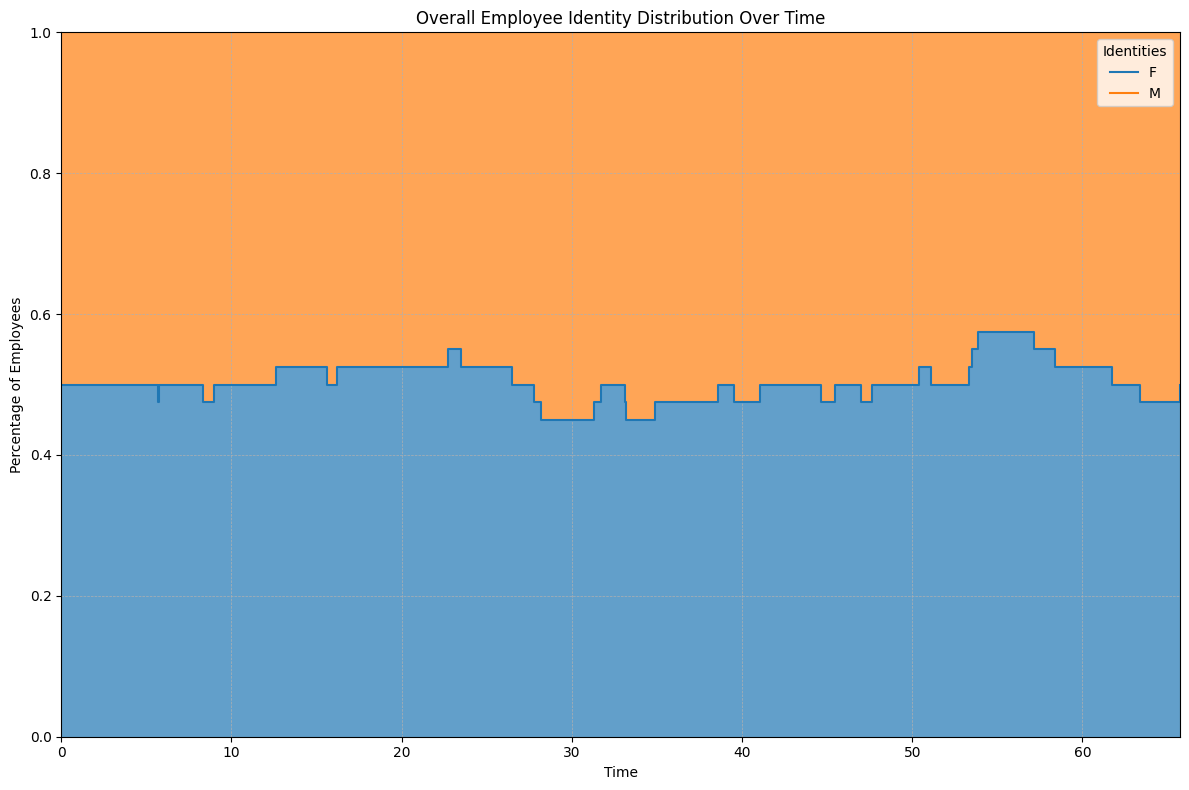

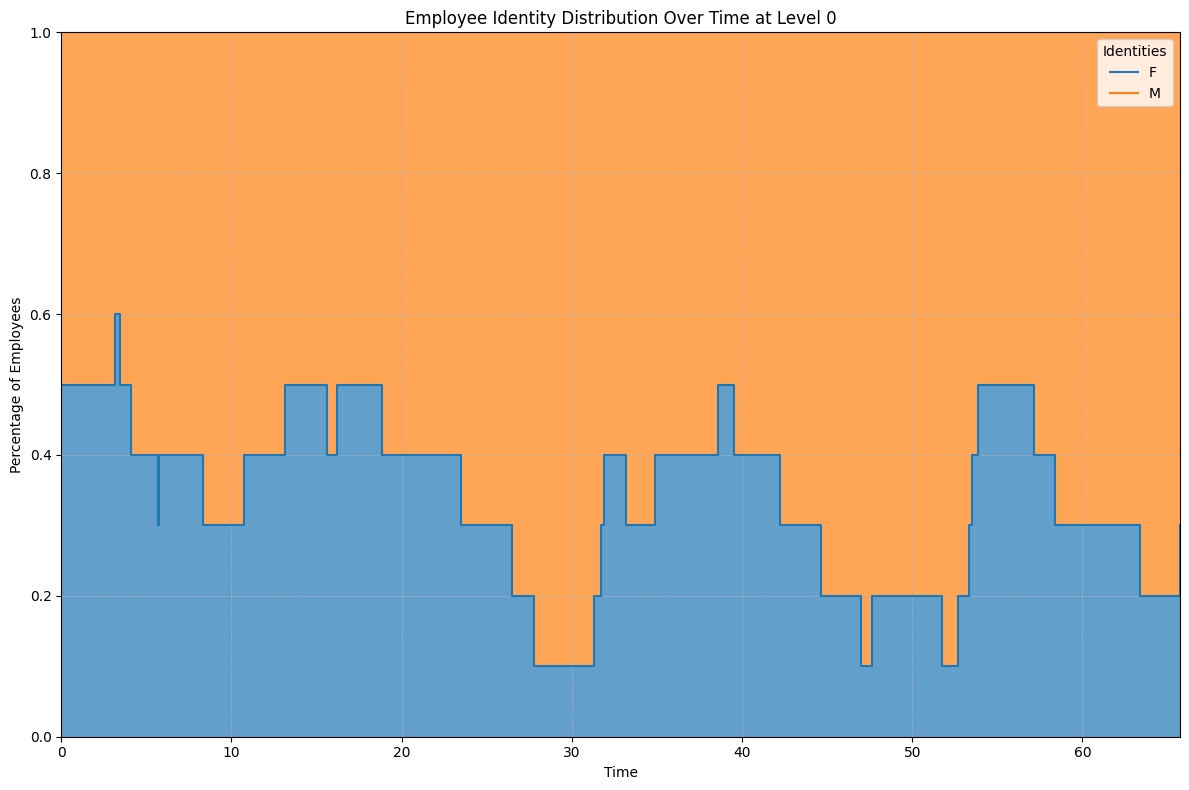

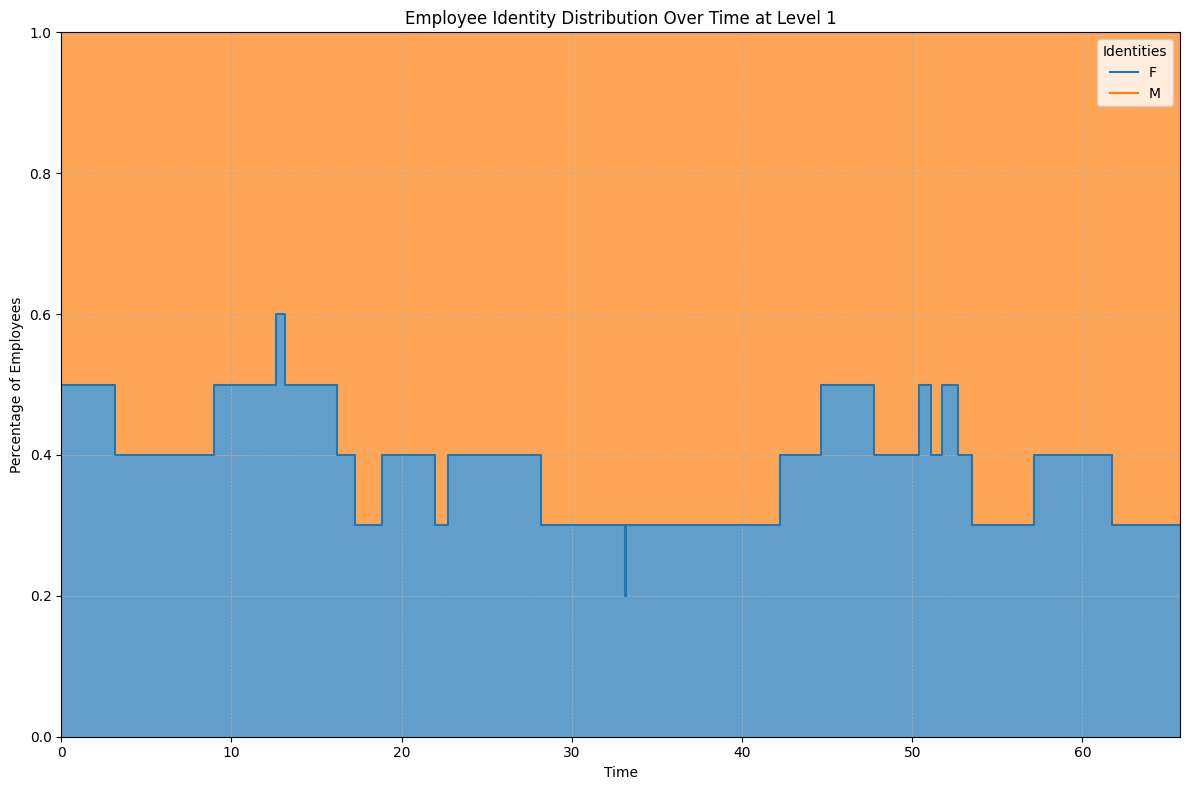

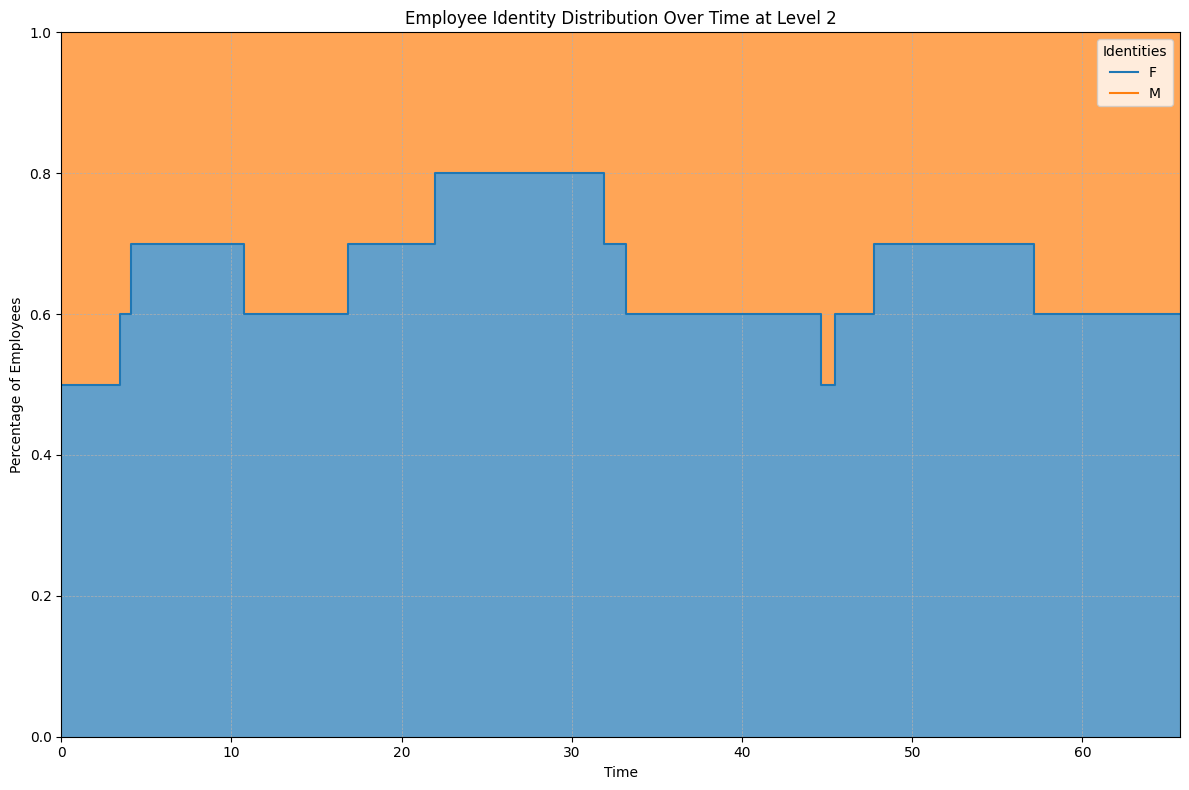

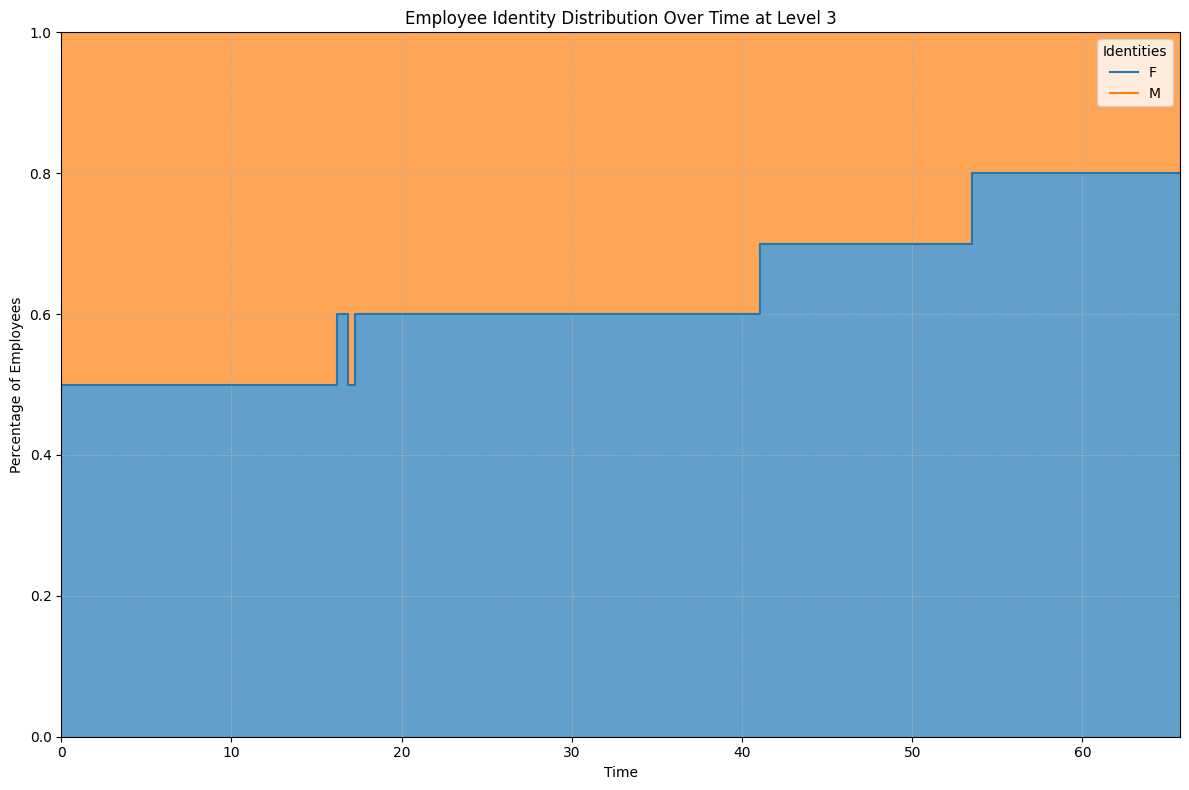

In [15]:
simplepath = test_simple_workplace_model(simple_params, simple_state)

## §3. Implementing a more extensible model for the project

In [16]:
@dataclass(frozen=True)
class Employee:
    identity: str
    hiring_and_promotion_times: tuple[float, ...]
    levels: List[str] = field(default_factory=list)
    identities: List[str] = field(default_factory=list)

    @property
    def level(self):
        return self.levels[len(self.hiring_and_promotion_times) - 1]

    @property
    def current_level_time(self):
        return self.hiring_and_promotion_times[-1]

    @staticmethod
    def sample_new_hire(ps, t_now, identities, levels):
        identity = np.random.choice(identities, p=ps)
        return Employee(
            identity,
            (t_now,),
            levels,
            identities,
        )

    def promoted(self, t_now):
        return Employee(
            self.identity,
            (*self.hiring_and_promotion_times, t_now),
            self.levels,
            self.identities
        )


@dataclass(frozen=True)
class ComplexWorkplaceState:
    levels: List[str] = field(default_factory=list)
    identities: List[str] = field(default_factory=list)
    state: Dict[str, Dict[str, List[Employee]]] = field(default_factory=dict)
    
    def to_simple_state(self):
        simple_state = {}
        for level in self.levels:
            simple_state[level] = {}
            for identity in self.identities:
                simple_state[level][identity] = len(self.state[level][identity])
        return SimpleWorkplaceState(
            self.levels,
            self.identities,
            simple_state
        )
    
    def __post_init__(self):
        n = len(self.levels)
        m = len(self.identities)
                
        # Validate State
        if len(self.state.keys()) != n:
            raise ValueError(f"State does not match levels: {self.state.keys()} (# levels {n})")
        for level in self.levels:
            if len(self.state[level].keys()) != m:
                raise ValueError(f"State does not match identities: ({self.state[level].keys()} {level}) (# identities {m})")
    

@dataclass(frozen=True)
class ComplexWorkplaceParams:
    levels: List[str] = field(default_factory=list) # Levels must be in order of lowest to highest within the list
    identities: List[str] = field(default_factory=list)
    employee_targets: Dict[str, int] = field(default_factory=dict)
    weights: Dict[str, Dict[str, int]] = field(default_factory=dict)
    lambdas: Dict[str, Dict[str, int]] = field(default_factory=dict)
        
    def __post_init__(self):
        n = len(self.levels)
        m = len(self.identities)
        
        # Validate employee targets
        if len(self.employee_targets.keys()) != n:
            raise ValueError(f"Targets do not match levels: {self.employee_targets.keys()} (# levels {n})")
          
        # Validate weights
        if len(self.weights.keys()) != n:
            raise ValueError(f"Weights do not match levels: {self.weights.keys()} (# levels {n})")
        for level in self.levels:
            if len(self.weights[level].keys()) != m:
                raise ValueError(f"Weights do not match identities: ({self.weights[level].keys()} {level}) (# identities {m})")
                
        # Validate lambdas
        if len(self.lambdas.keys()) != n:
            raise ValueError(f"Lambdas do not match levels: {self.lambdas.keys()} (# levels {n})")
        for level in self.levels:
            if len(self.lambdas[level].keys()) != m:
                raise ValueError(f"Lambdas do not match identities: ({self.lambdas[level].keys()} {level}) (# identities {m})")
                
        # Do more checks to ensure that values are all positive
        
        
@dataclass(frozen=True)
class ComplexWorkplaceModel:
    params: ComplexWorkplaceParams

    def transition_rate(self, state: ComplexWorkplaceState):
        simple_state = state.to_simple_state()
        rate = 0
        for level in self.params.levels:
            for identity in self.params.identities:
                if simple_state.state[level][identity] > 0:
                    rate += self.params.lambdas[level][identity]
        return rate

    def sample_next(self, state: ComplexWorkplaceState):
        simple_state = state.to_simple_state()
        transitions = []
        for level in self.params.levels:
            for identity in self.params.identities:
                if simple_state.state[level][identity] > 0:
                    transitions.append((level, identity, self.params.lambdas[level][identity]))
        rates = np.array([transition[2] for transition in transitions])
        probabilities = rates / rates.sum()
        sampled_index = np.random.choice(len(transitions), p=probabilities)
        sampled_level, sampled_identity, _ = transitions[sampled_index]
        new_state = {level: dict(identities) for level, identities in state.state.items()}
        employees = new_state[sampled_level][sampled_identity]
        remove_index = RNG.integers(low=0, high=len(employees))
        new_state[sampled_level][sampled_identity] = employees[:remove_index] + employees[remove_index + 1:]
        state = ComplexWorkplaceState(state.levels, state.identities, new_state)
        return self.update_state(state, sampled_level, sampled_identity)

    def update_state(self, state: ComplexWorkplaceState, departure_level: str, departure_identity: str):
        if departure_level not in self.params.levels:
            raise ValueError(f"Invalid departure level: {departure_level}")
        if departure_identity not in self.params.identities:
            raise ValueError(f"Invalid departure identity: {departure_identity}")
        
        new_state = {level: dict(identities) for level, identities in state.state.items()}
        
        departure_level_index = self.params.levels.index(departure_level)
        if departure_level_index == 0:
            weights = np.array([self.params.weights[departure_level][identity] for identity in self.params.identities])
            probabilities = weights / weights.sum()
            employee = Employee.sample_new_hire(probabilities, 0, self.params.identities, self.params.levels)
            new_state[departure_level][employee.identity].append(employee) # TODO: Figure out how to get time
            return ComplexWorkplaceState(state.levels, state.identities, new_state)
        else:
            prev_departure_level = self.params.levels[departure_level_index - 1]
            weights = np.array([self.params.weights[departure_level][identity] for identity in self.params.identities])
            populations = np.array([len(state.state[prev_departure_level][identity]) for identity in self.params.identities])
            total_weighted_population = weights * populations
            probabilities = total_weighted_population / total_weighted_population.sum()
            new_identity = np.random.choice(self.params.identities, p=probabilities)
            promote_index = RNG.integers(low=0, high=len(new_state[prev_departure_level][new_identity]))
            promote_employee = new_state[prev_departure_level][new_identity][promote_index]
            promote_employee.promoted(0)
            new_state[departure_level][new_identity].append(promote_employee)
            new_state[prev_departure_level][departure_identity] = new_state[prev_departure_level][departure_identity][:promote_index] + new_state[prev_departure_level][departure_identity][promote_index + 1:]
            state = ComplexWorkplaceState(state.levels, state.identities, new_state)
            return self.update_state(state, prev_departure_level, new_identity)

In [17]:
def test_complex_workplace_model(
    params: ComplexWorkplaceParams,
    initial_state: ComplexWorkplaceState,
    n_iters=64
):
    model = ComplexWorkplaceModel(params)
    path = run_ctmc(model, initial_state, n_iters)
    simple_path = [(time, state.to_simple_state()) for time, state in path]
    visualize_path_percentage(simple_path, params.identities, params.levels)
    visualize_path_percentage_by_level(simple_path, params.identities, params.levels)
    return path

In [18]:
complex_state_dict = {}
for level in levels:
    complex_state_dict[level] = {}
    for identity in identities:
        complex_state_dict[level][identity] = ([Employee(
            identity,
            (0,),
            levels,
            identities,
        ) for I in range(5)])
complex_params = ComplexWorkplaceParams(levels, identities, employee_targets, weights, lambdas)
complex_state = ComplexWorkplaceState(levels, identities, complex_state_dict)

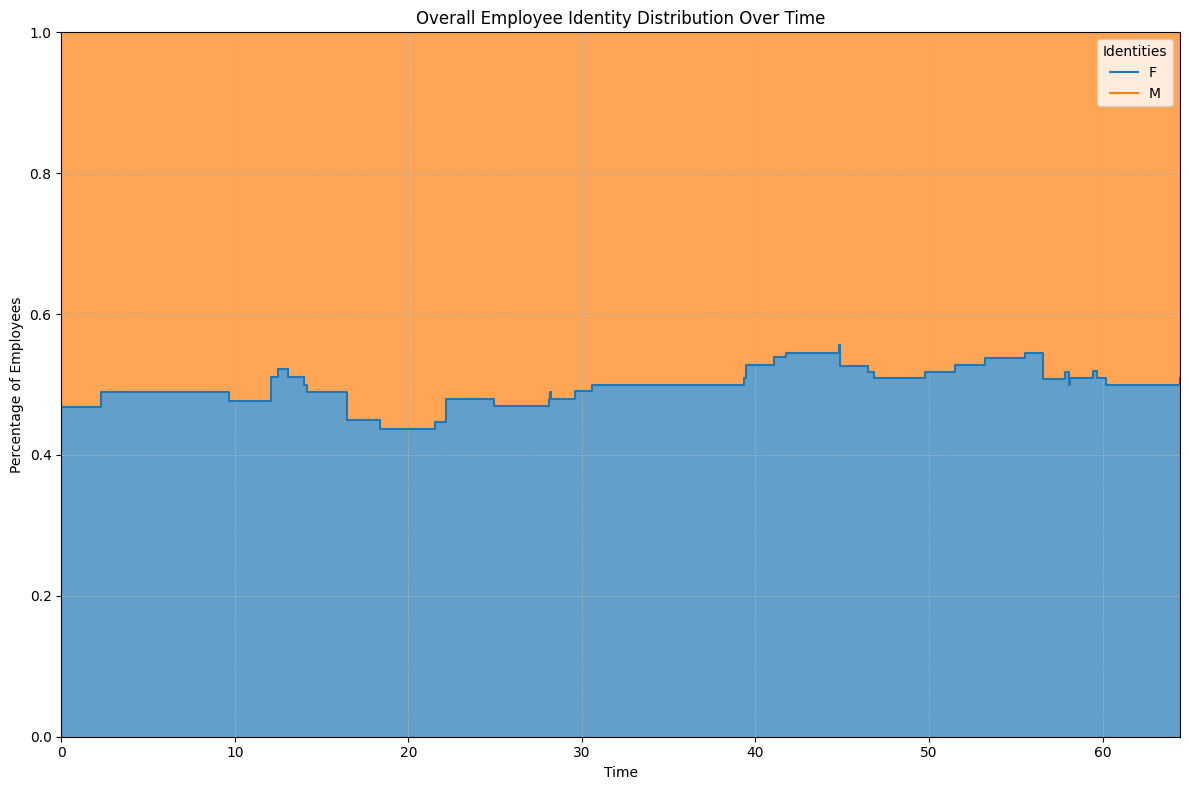

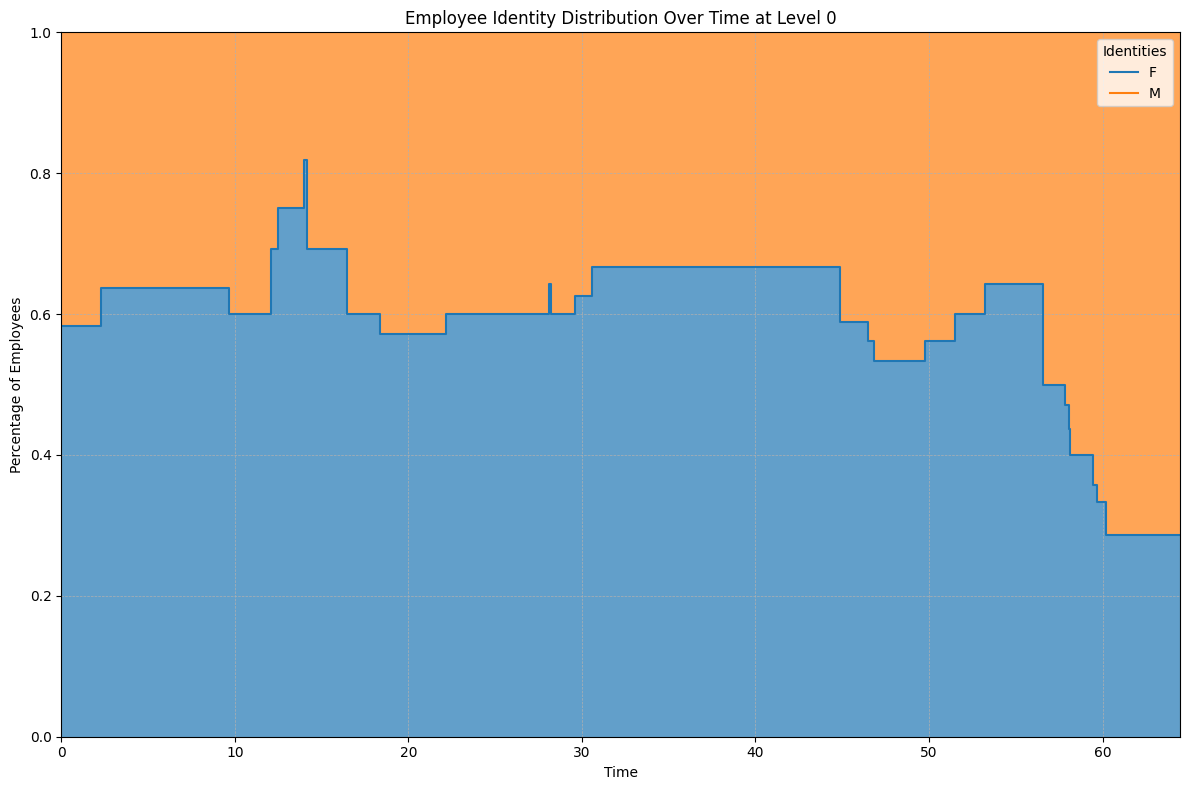

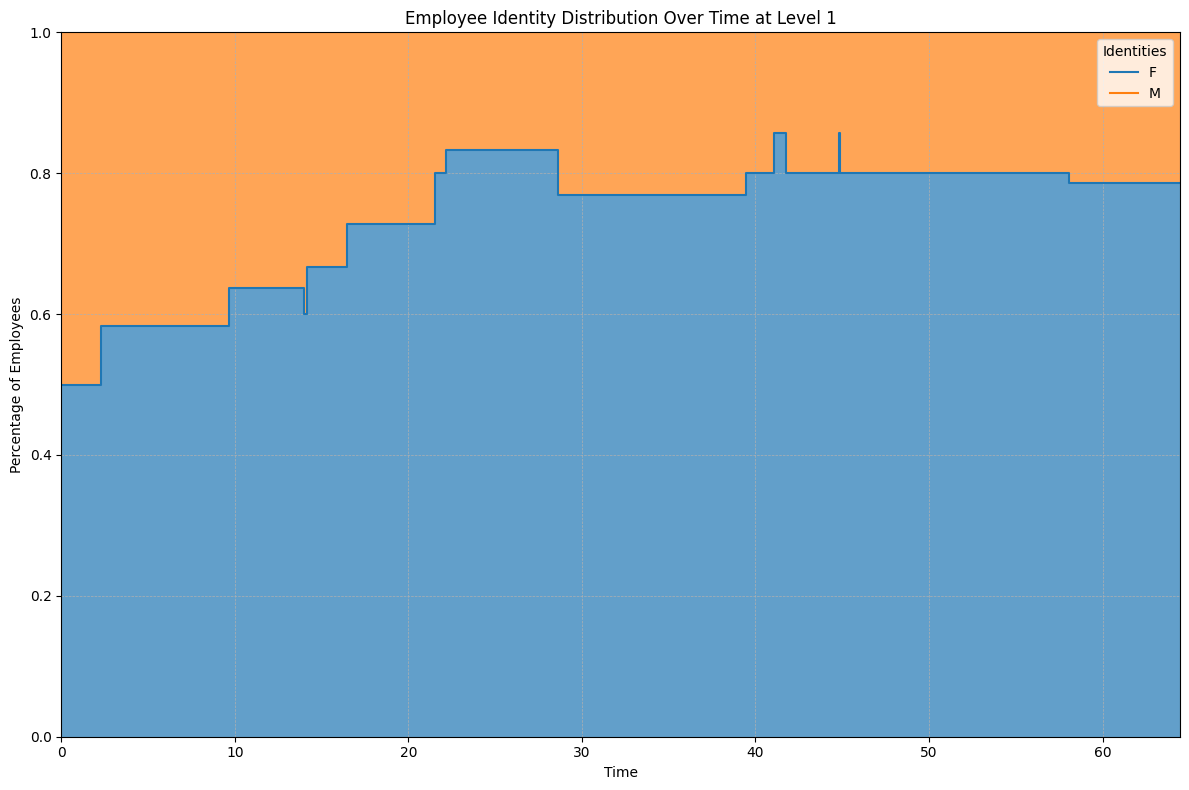

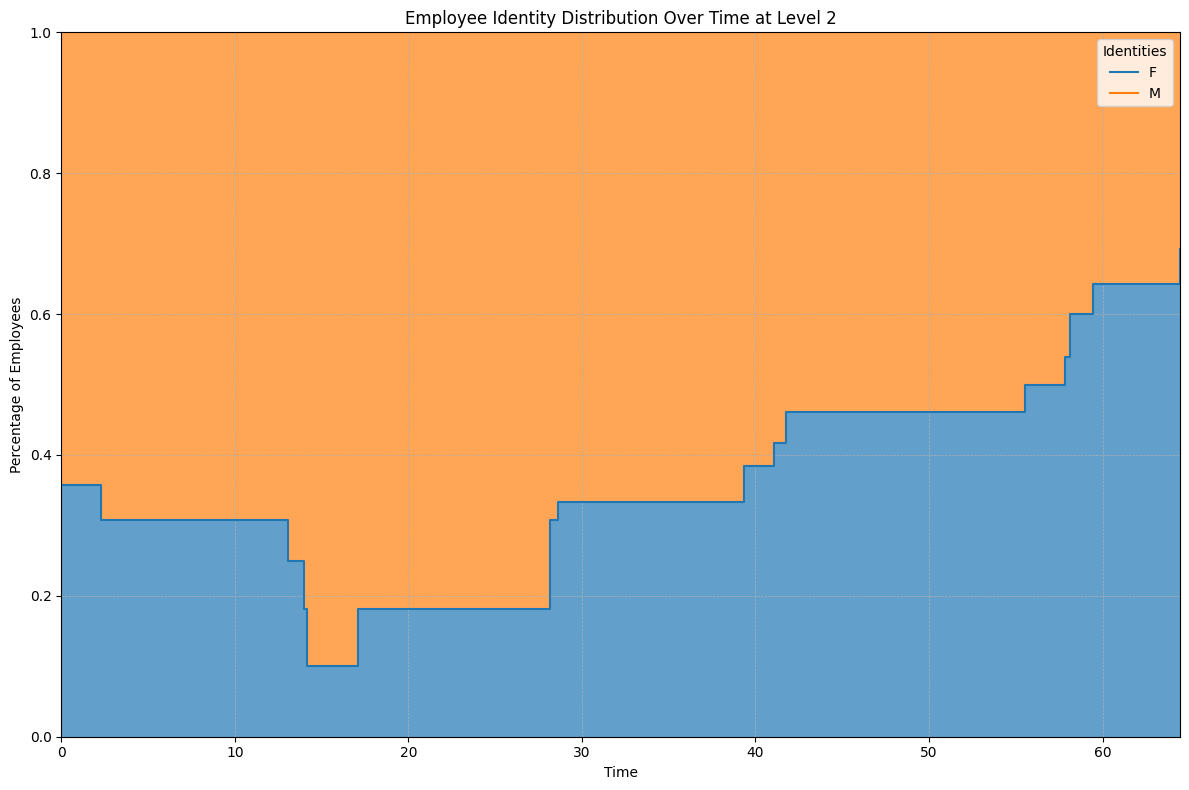

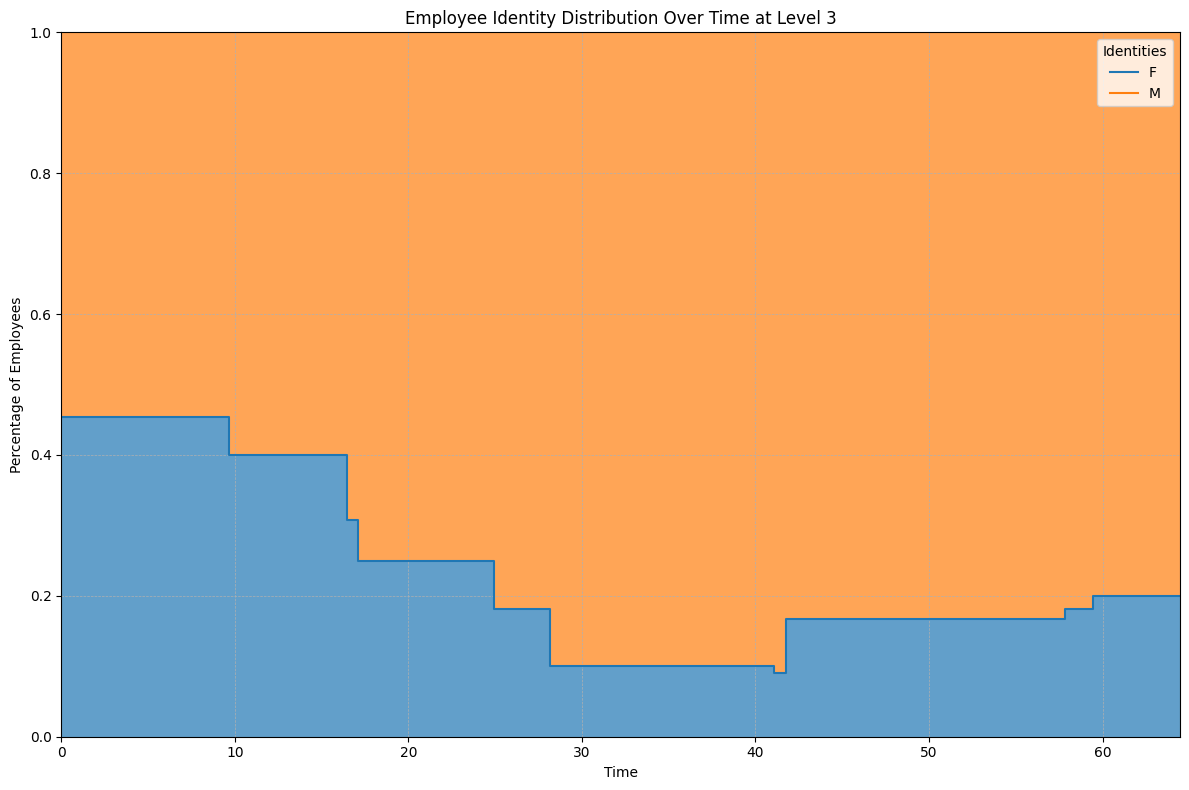

In [19]:
complex_path = test_complex_workplace_model(complex_params, complex_state)

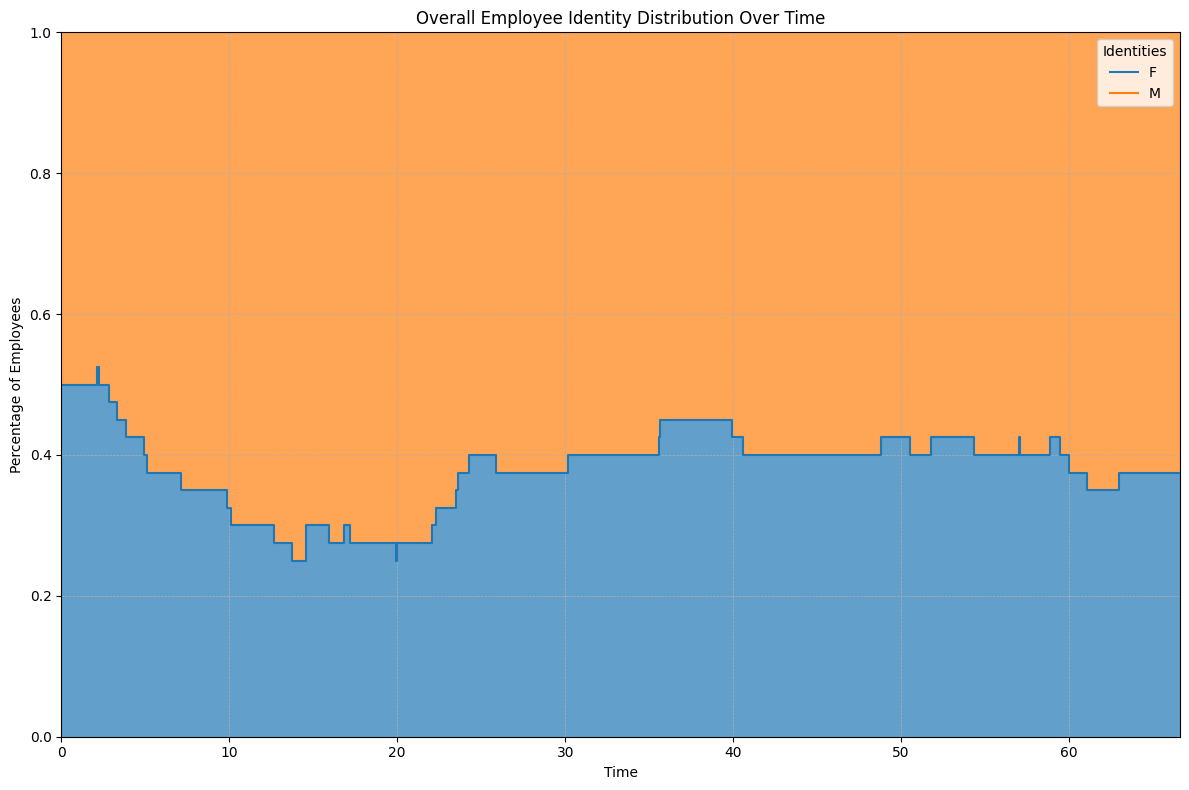

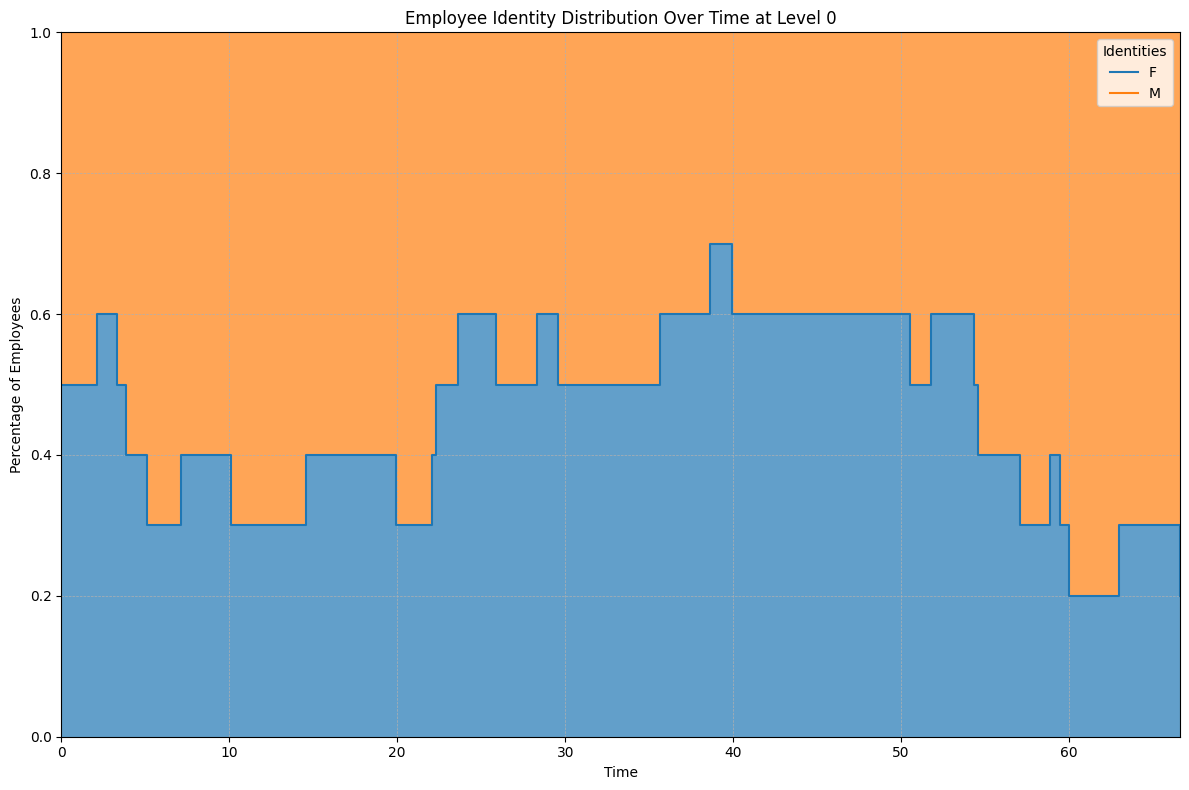

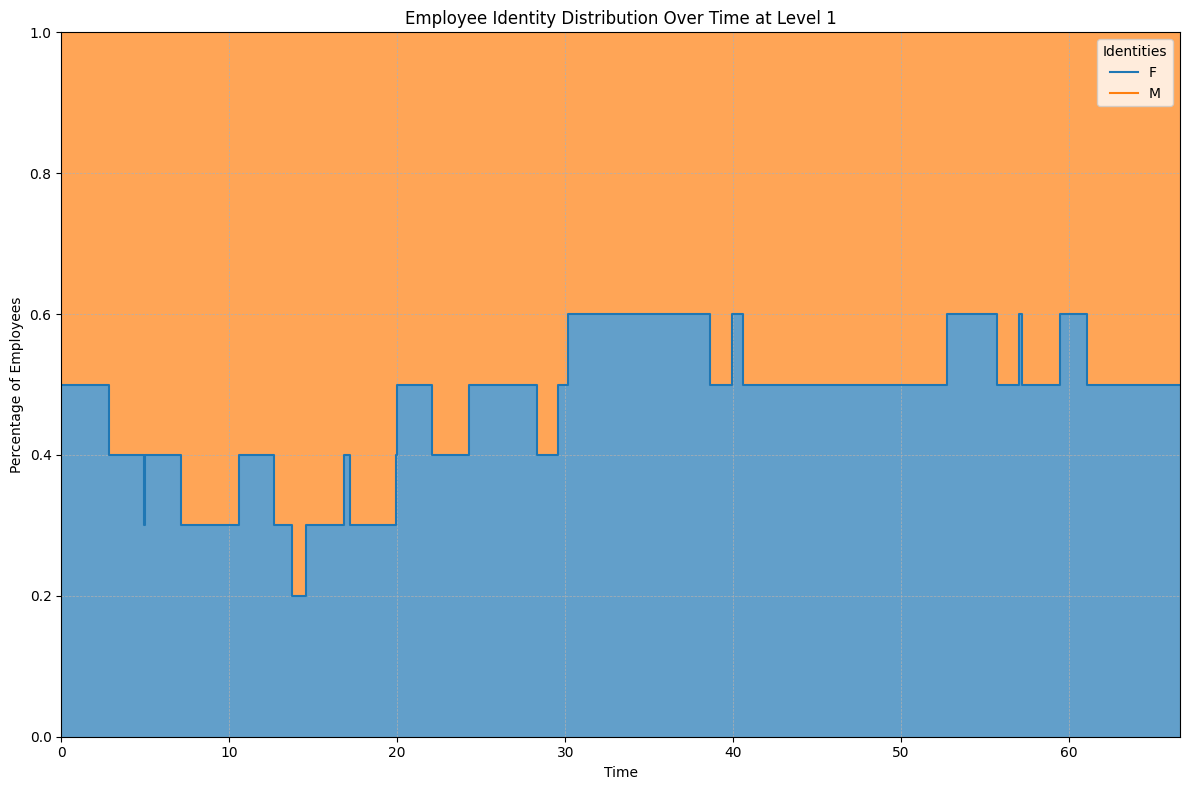

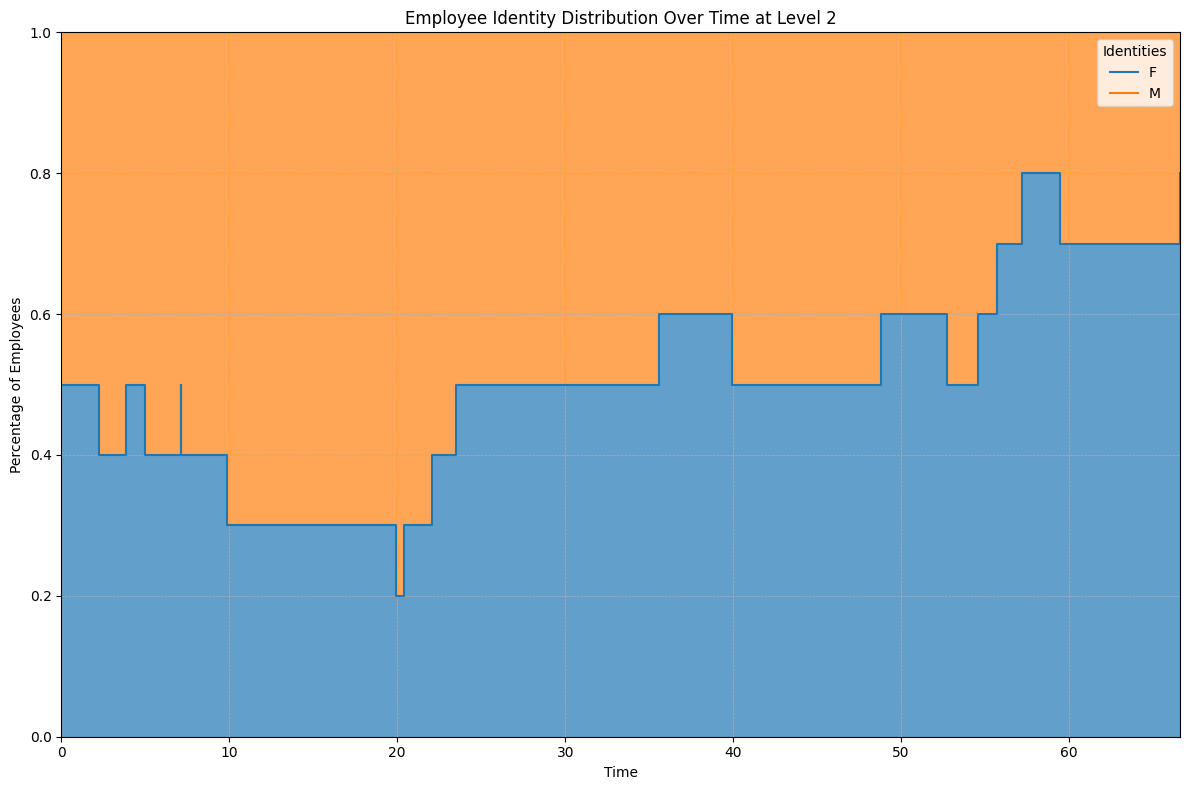

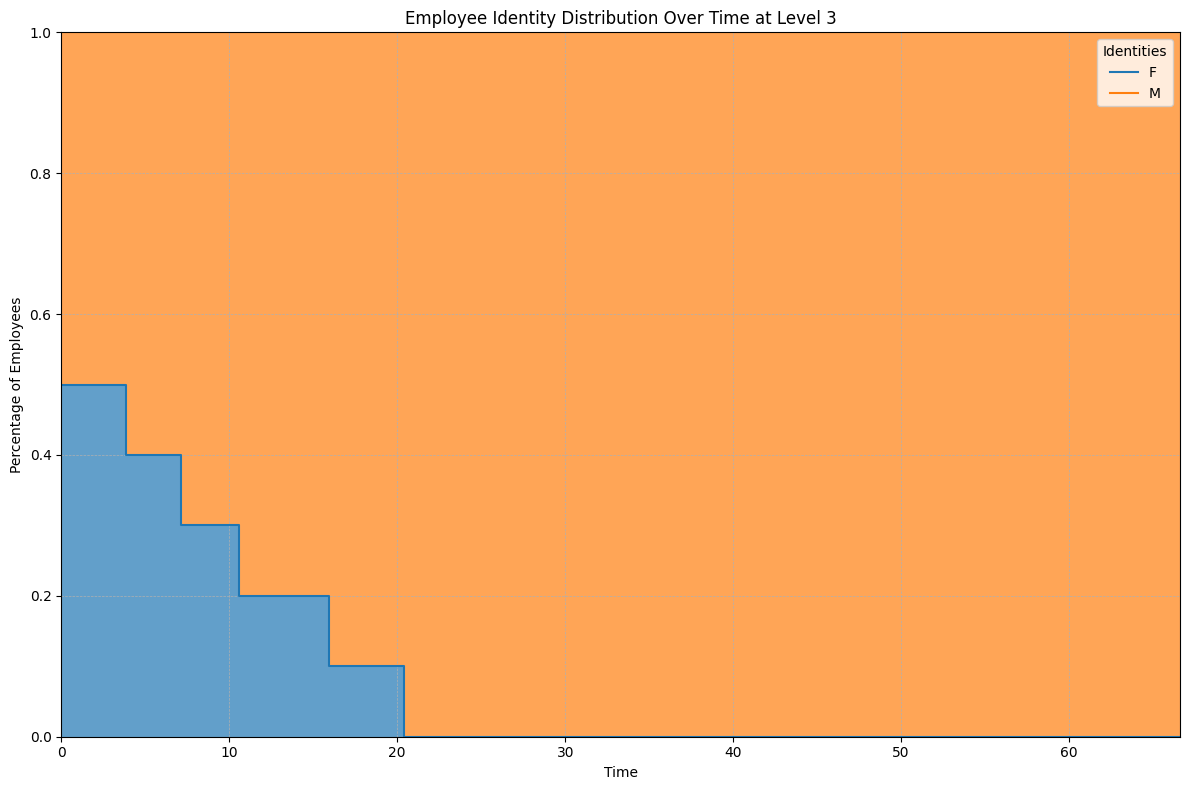

In [20]:
simplepath = test_simple_workplace_model(simple_params, simple_state)